In [1]:
import numpy as np
import matplotlib.pyplot as plt
import autokeras as ak
import tensorflow as tf
import os

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Convolution2D, MaxPooling2D , Lambda, Conv2D, Activation,Concatenate
from tensorflow.keras.layers import ActivityRegularization, BatchNormalization
from tensorflow.keras.optimizers import Adam , SGD , Adagrad
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, CSVLogger, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers , initializers
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import NumpyArrayIterator
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import backend as K

In [3]:
import logging

logging.basicConfig(level = logging.INFO)

gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#   # Restrict TensorFlow to only use the first GPU
try:
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    tf.config.experimental.set_virtual_device_configuration(
    gpus[0],
    [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5000)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
#     logging.info(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
except RuntimeError as e:
# Visible devices must be set before GPUs have been initialized
    logging.info(e)

In [6]:
exposure = ''
data = np.load('/home/ML4NO/Data/n1000000{}_0910_classification.npz'.format(exposure))

In [7]:
data_selection = 1 # 0 for all, 1 for lowE(<5GeV), 2 for high(>5GeV)

if data_selection == 0:
    data_all = np.column_stack([data['ve_dune'], data['vu_dune'], data['vebar_dune'], data['vubar_dune']])
    directory = './models_all_sigmoid/'
elif data_selection == 1:
    data_all = np.column_stack([data['ve_dune'][:,:36], data['vu_dune'][:,:36], data['vebar_dune'][:,:36], data['vubar_dune'][:,:36]])
    directory = './models_lowE_sigmoid/'
elif data_selection == 2:
    data_all = np.column_stack([data['ve_dune'][:,36:], data['vu_dune'][:,36:], data['vebar_dune'][:,36:], data['vubar_dune'][:,36:]])
    directory = './models_highE_sigmoid/'
target = data['cpv']

x_train = data_all[:10000]
y_train = target[:10000]
x_train2 = data_all[10000:900000]
y_train2 = target[10000:900000]
x_test = data_all[900000:]
y_test = target[900000:]

In [9]:
def DNN_Model(name):
    model_DNN = Sequential(name = "Model_DNN_"+str(name))  
    model_DNN.add(keras.Input(shape=(len(x_train[0]),), name = 'input'))
    model_DNN.add(BatchNormalization(name = 'BatchNormalization'))
    model_DNN.add(Dense(1024, activation='relu', name = 'dense_1'))
    model_DNN.add(Dense(1024, activation='relu', name = 'dense_2'))
    model_DNN.add(Dense(1024, activation='relu', name = 'dense_3'))
    model_DNN.add(Dense(1024, activation='relu', name = 'dense_4'))
    model_DNN.add(Dense(1024, activation='relu', name = 'dense_5'))
    model_DNN.add(Dense(1024, activation='relu', name = 'dense_6'))
    model_DNN.add(Dense(1, activation='sigmoid', name = 'output'))
    model_opt = keras.optimizers.Adam()
    model_DNN.compile(loss="binary_crossentropy",
                              optimizer=model_opt,
                              metrics=['accuracy'])
    model_DNN.summary()
    return model_DNN

In [10]:
model = DNN_Model("classification")

Model: "Model_DNN_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
BatchNormalization (BatchNor (None, 144)               576       
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              148480    
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dense_5 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dense_6 (Dense)              (None, 1024) 

In [11]:
model.fit(x_train2, y_train2,
           validation_split = 0.1,
           batch_size=64,
           epochs=5,
           verbose=1,
           shuffle = True
         )

Epoch 1/5
12516/12516 [==============================] - 80s 6ms/step - loss: 0.2786 - accuracy: 0.8961 - val_loss: 0.1687 - val_accuracy: 0.9393
Epoch 2/5
12516/12516 [==============================] - 80s 6ms/step - loss: 0.2023 - accuracy: 0.9302 - val_loss: 0.1449 - val_accuracy: 0.9519
Epoch 3/5
12516/12516 [==============================] - 79s 6ms/step - loss: 0.2116 - accuracy: 0.9285 - val_loss: 0.2415 - val_accuracy: 0.9110
Epoch 4/5
12516/12516 [==============================] - 79s 6ms/step - loss: 0.2034 - accuracy: 0.9302 - val_loss: 0.1785 - val_accuracy: 0.9366
Epoch 5/5
12516/12516 [==============================] - 79s 6ms/step - loss: 0.1956 - accuracy: 0.9330 - val_loss: 0.1579 - val_accuracy: 0.9444


In [13]:
model_index = 1
while os.path.isfile(directory + 'models/0910{}_{}.h5'.format(exposure, model_index)):
    model_index += 1
model.save(directory + 'models/0910{}_{}.h5'.format(exposure, model_index), overwrite=False)

In [14]:
furthur_index = 1
path = directory + 'models_furthurTrain/0910{}_{}_{}'
while os.path.isdir(path.format(exposure, model_index, furthur_index)):
    furthur_index += 1

In [15]:
scale_steps = np.logspace(-3, 0, 30)
before_train_loss = []
after_train_loss = []

for scale in scale_steps:
    x_train2_gen = np.random.normal(x_train2, np.sqrt(x_train2)*scale)
    x_test_gen = np.random.normal(x_test, np.sqrt(x_test)*scale)

    before_train_loss.append(model.evaluate(x_test_gen, y_test)[0])

    model.fit(x_train2_gen, y_train2,
               validation_split = 0.1,
               batch_size=64,
               epochs=5,
               verbose=1,
               shuffle = True
             )

    after_train_loss.append(model.evaluate(x_test_gen, y_test)[0])
    model.save(path.format(exposure, model_index, furthur_index) + '/std={}.h5'.format(scale))
model.save(path.format(exposure, model_index, furthur_index) + '.h5')

3125/3125 [==============================] - 10s 3ms/step - loss: 0.1557 - accuracy: 0.9452
Epoch 1/5
12516/12516 [==============================] - 79s 6ms/step - loss: 0.1948 - accuracy: 0.9334 - val_loss: 0.1985 - val_accuracy: 0.9284
Epoch 2/5
12516/12516 [==============================] - 79s 6ms/step - loss: 0.1920 - accuracy: 0.9348 - val_loss: 0.1979 - val_accuracy: 0.9240
Epoch 3/5
12516/12516 [==============================] - 79s 6ms/step - loss: 0.1950 - accuracy: 0.9325 - val_loss: 0.1634 - val_accuracy: 0.9460
Epoch 4/5
12516/12516 [==============================] - 79s 6ms/step - loss: 0.1932 - accuracy: 0.9359 - val_loss: 0.1487 - val_accuracy: 0.9498
Epoch 5/5
3125/3125 [==============================] - 10s 3ms/step - loss: 0.1689 - accuracy: 0.9413
Epoch 1/5
12516/12516 [==============================] - 79s 6ms/step - loss: 0.2091 - accuracy: 0.9364 - val_loss: 0.1555 - val_accuracy: 0.9465
Epoch 2/5
12516/12516 [==============================] - 79s 6ms/step - loss

In [16]:
Poisson_index = 1
path = directory + 'models_PoissonTrain/0910{}_{}_{}_{}'
while os.path.isdir(path.format(exposure, model_index, furthur_index, Poisson_index)):
    Poisson_index += 1

In [ ]:
x_test_gen = np.random.poisson(x_test)

for i in range(10):
    x_train2_gen = np.random.poisson(x_train2)
    
    model.fit(x_train2_gen, y_train2,
              validation_split=0.1,
               batch_size=64,
               epochs=1,
               verbose=1,
               shuffle = True
             )
    model.save(path.format(exposure, model_index, furthur_index, Poisson_index) + '/steps={}.h5'.format(i))
model.save(path.format(exposure, model_index, furthur_index, Poisson_index) + '.h5')
model.evaluate(x_test_gen, y_test)

12510/12516 [============================>.] - ETA: 0s - loss: 0.3690 - accuracy: 0.8397

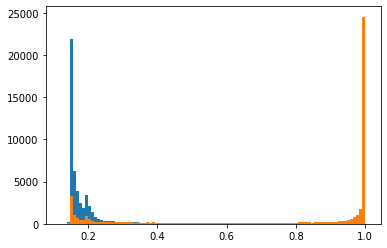

In [10]:
cpc = np.where(y_test == 0)
cpv = np.where(y_test == 1)
plt.hist(pred[cpc], bins =100)
plt.hist(pred[cpv], bins = 100)
plt.show()

In [4]:
exposure = ''
model = tf.keras.models.load_model('./models_lowE_sigmoid/models_PoissonTrain/0910{}_1_1_1.h5'.format(exposure))

In [8]:
x_test_gen = np.random.poisson(x_test)
pred = model.predict(x_test_gen)

In [12]:
min(pred)

array([0.12180763], dtype=float32)

In [15]:
max(pred)

array([1.], dtype=float32)

In [19]:
np.median(pred[cpc])

0.160059

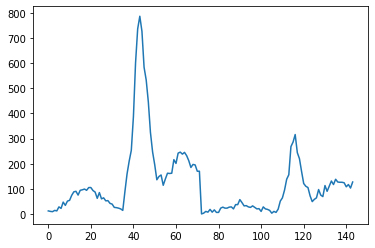

In [21]:
plt.plot(x_test_gen[0])

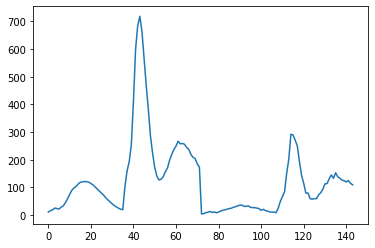

In [23]:
plt.plot(x_train[0])